# Generate ground truth for Bayesian inversion problem

In [2]:
import sys
import os
import time
import numpy as np
import dolfin as dl

from scipy.interpolate import griddata

src_path = "../../../src/"
sys.path.append(src_path + 'plotting')
from field_plot import *
from plot_mix_collection import *
from point_plot import *


sys.path.append(src_path + 'pde')
from fenicsUtilities import function_to_vertex

sys.path.append(src_path + 'prior')
from priorSampler import PriorSampler

model_path = "../../problems/linear_elasticity/"
sys.path.append(model_path)
from linearElasticityModel import LinearElasticityModel

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)

In [3]:
data_folder = 'Results/ground_truth/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Create a deterministic Young's modulus field and add some small noise to generate ground truth

In [4]:
prior_ac = 0.005
prior_cc = 0.2
prior_logn_scale = 100.
prior_logn_translate = 1000.
nx, ny = 50, 50
fe_order = 1
data_prefix = 'LinearElasticity'

# create mesh
mesh = dl.UnitSquareMesh(nx, ny)

# create function spaces
Vm = dl.FunctionSpace(mesh, 'Lagrange', fe_order)
Vu = dl.VectorFunctionSpace(mesh, "Lagrange", fe_order)

# create prior sampler
prior_sampler = PriorSampler(Vm, prior_ac, prior_cc, seed)

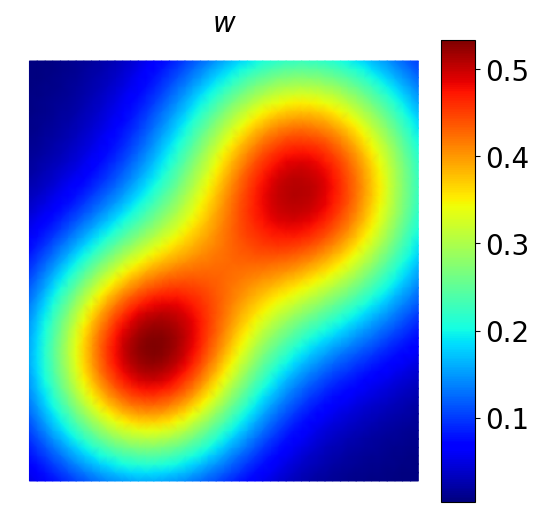

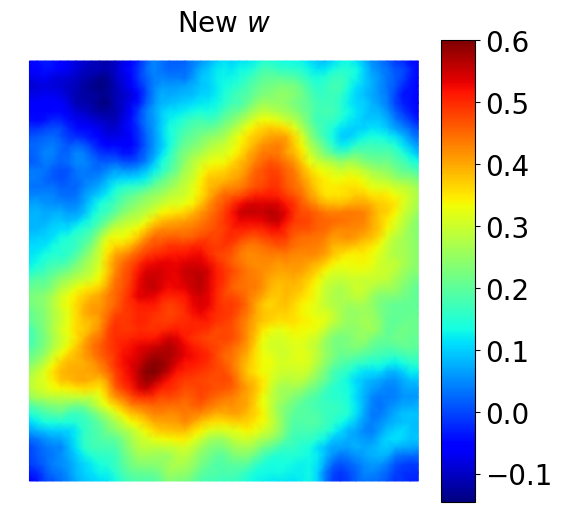

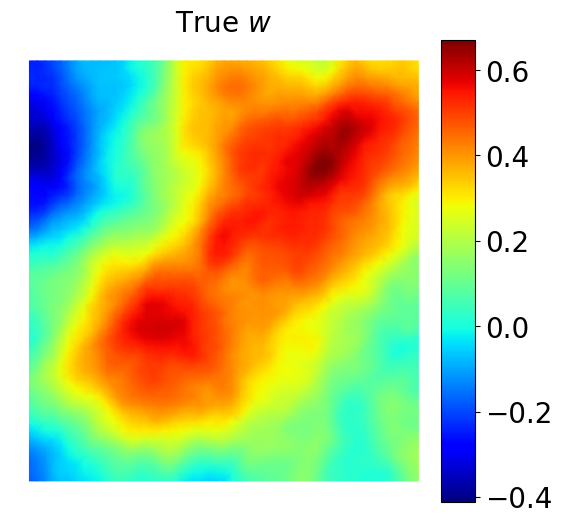

In [29]:
# create a function 
def w_field(x):
    xc, yc, r = 0.35, 0.65, 0.2
    vin, vout = 0.3, -0.3
    a, b = vin, np.log(vin - vout)
    tol = 1.e-12

    # check relative position of point x
    xx, yy = x[0] - xc, x[1] - yc
    f = (r*r - xx*xx - yy*yy)/(r*r)
    
    # set values
    if f < 1.+tol:
        # return -0.2*(2*check + 1)
        return a*np.exp(-b*f)
    else:
        return vout
    
def multi_mode_w_field(x):
    vin, vout = 0.3, -0.3
    a, b = vin, np.log(vin - vout)
    tol = 1.e-12

    xc = [[0.7, 0.7, 0.24], [0.3, 0.3, 0.2]]
    

    # check relative position of point x
    val = 0.
    for i in range(len(xc)):
        xx, yy = x[0] - xc[i][0], x[1] - xc[i][1]
        r = xc[i][2]
        f = (r*r - xx*xx - yy*yy)/(r*r)
        if f < 1.+tol:
            val = val + a*np.exp(-b*f)
        else:
            val = val + vout
    return val
    
w_fn = dl.Function(Vm)
w = function_to_vertex(w_fn, None, prior_sampler.V)
w[:] = np.array([multi_mode_w_field(x) for x in mesh.coordinates()])

quick_field_plot(w, mesh.coordinates(), title=r'$w$')

w = w + 0.5*prior_sampler()[0]

quick_field_plot(w, mesh.coordinates(), title=r'New $w$')

save_w = False
if save_w:
    np.save(results_dir + 'w_true.npy', w)
    quick_field_plot(w, mesh.coordinates(), title=r'True $w$')
else:
    w_true = np.load(results_dir + 'w_true.npy')
    quick_field_plot(w_true, mesh.coordinates(), title=r'True $w$')

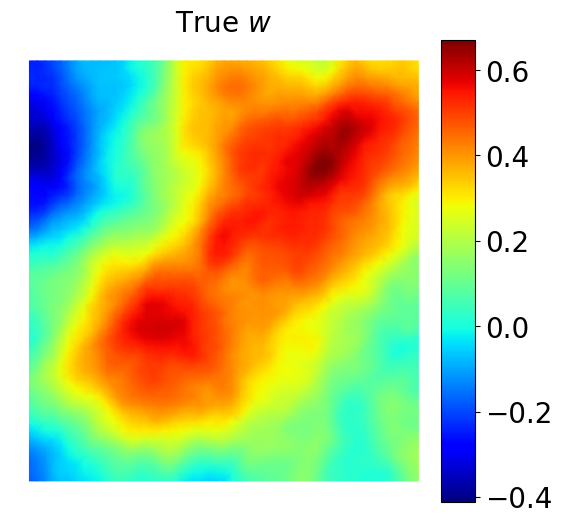

In [28]:
np.save(results_dir + 'w_true.npy', w)
quick_field_plot(w, mesh.coordinates(), title=r'True $w$')

# Create LinearElasticityModel and generate ground truth

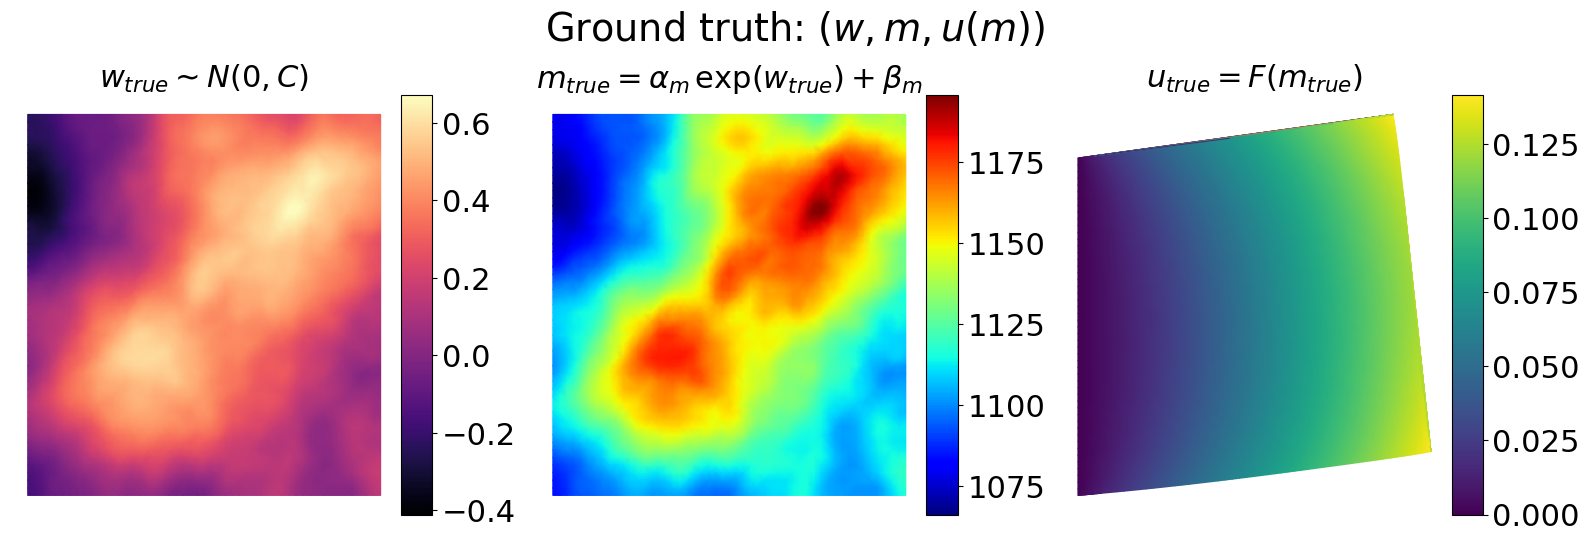

In [30]:
# create model
model = LinearElasticityModel(Vm, Vu, prior_sampler, prior_logn_scale, prior_logn_translate, seed)

# load mean sample for Bayesian inversion
w_true = np.load(results_dir + 'w_true.npy')
m_true = model.transform_gaussian_pointwise(w_true)

# solve for u at true m
u_true = model.solveFwd(u = None, m = m_true, transform_m = False)

# plot the loaded m and true u
uvec = [[w_true, m_true, u_true]]
title_vec = [[r'$w_{true} \sim N(0, C)$', r'$m_{true} = \alpha_m\, \exp(w_{true}) + \beta_m$', r'$u_{true} = F(m_{true})$']]
cmap_vec = [['magma', 'jet', 'viridis']]
flag_is_vec = [[False, False, True]]
flag_add_disp = [[False, False, True]]
plot_type = [['field' for _ in range(3)]]

plot_data = get_default_plot_mix_collection_data(rows = 1, \
    cols = 3, \
    nodes = model.u_nodes, \
    figsize = (16, 5), fs = 22, \
    sup_title = r'Ground truth: $(w, m, u(m))$', \
    y_sup_title = 1.075, \
    savefilename = results_dir + 'true_w_m_u.png', \
    u = uvec, cmap = cmap_vec, title = title_vec, \
    is_vec = flag_is_vec, add_disp = flag_add_disp, \
    plot_type = plot_type)

plot_mix_collection(plot_data)

# State to observable - interpolate temperature at grid points which will serve as observable

x_obs.shape = (256, 2)
grid_w.shape = (16, 16), grid_m.shape = (16, 16), grid_u.shape = (16, 16, 2)
w_obs.shape = (256,), m_obs.shape = (256,), u_obs.shape = (512,)


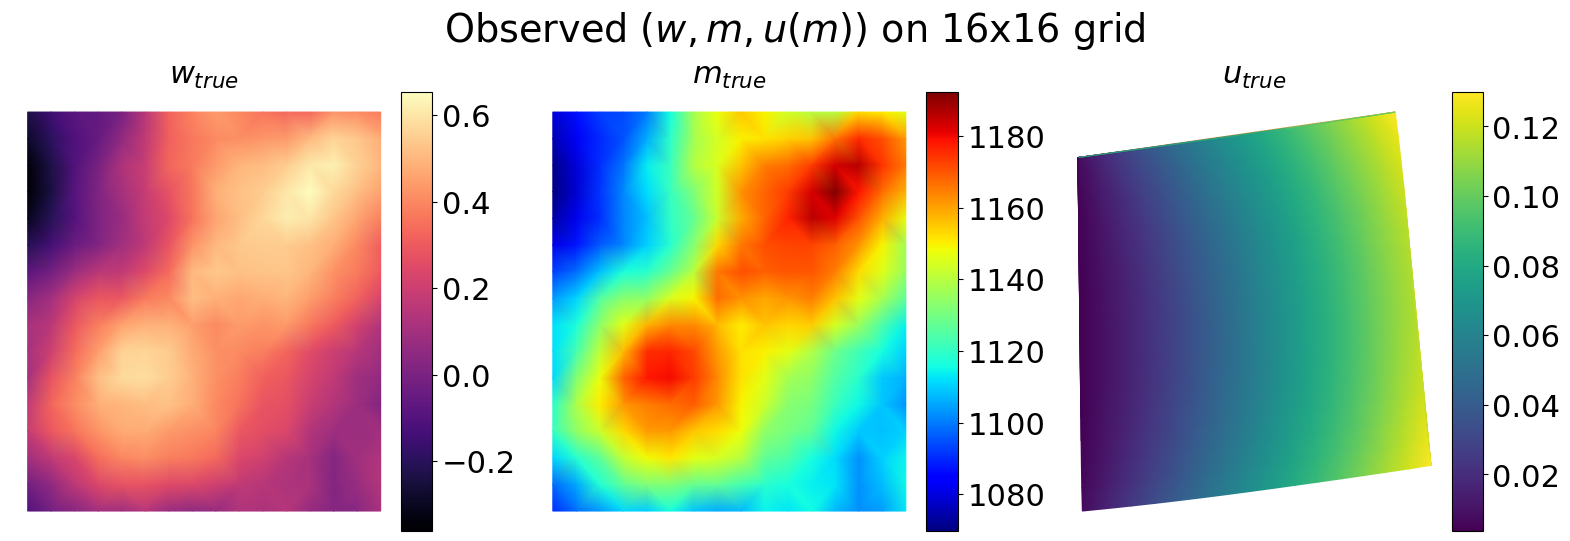

In [ ]:
# get set of points on area of interest
num_grid_x, num_grid_y = 16, 16
grid_x, grid_y = np.meshgrid(np.linspace(0.05, 0.95, num_grid_x), np.linspace(0.05, 0.95, num_grid_y), indexing='ij')
x_obs = np.vstack([grid_x.flatten(), grid_y.flatten()]).T

print('x_obs.shape = {}'.format(x_obs.shape))

# interpolate u at grid points
# grid_w = griddata(model.m_nodes, w_true, (grid_x, grid_y), method='linear')
grid_w = griddata(model.m_nodes, w_true, (x_obs[:,0].reshape(num_grid_x, num_grid_y), x_obs[:,1].reshape(num_grid_x, num_grid_y)), method='linear')
grid_m = griddata(model.m_nodes, m_true, (grid_x, grid_y), method='linear')

# since u is a vector field, we need to interpolate each component separately
num_nodes = model.u_nodes.shape[0]
grid_u = np.zeros((num_grid_x, num_grid_y, 2))
grid_u[:, :, 0] = griddata(model.u_nodes, u_true[:num_nodes], (grid_x, grid_y), method='linear')
grid_u[:, :, 1] = griddata(model.u_nodes, u_true[num_nodes:], (grid_x, grid_y), method='linear')

print('grid_w.shape = {}, grid_m.shape = {}, grid_u.shape = {}'.format(grid_w.shape, grid_m.shape, grid_u.shape))

# save ground truth
w_obs = grid_w.flatten() 
m_obs = grid_m.flatten() 
u_obs = np.hstack([grid_u[:,:,i].flatten() for i in range(2)])

print('w_obs.shape = {}, m_obs.shape = {}, u_obs.shape = {}'.format(w_obs.shape, m_obs.shape, u_obs.shape))

save_for_bayesian_grid_data = False
if save_for_bayesian_grid_data:
    np.savez(results_dir + 'data.npz', \
            num_grid_x = num_grid_x, num_grid_y = num_grid_y, \
            grid_x = grid_x, grid_y = grid_y, \
            grid_w = grid_w, grid_m = grid_m, grid_u = grid_u, \
            w_true = w_true, m_true = m_true, u_true = u_true, \
            x_obs = x_obs, \
            w_obs = w_obs, m_obs = m_obs, u_obs = u_obs)
else:
    print('*'*40)
    print('*'*40)
    print('Data is not saved!')
    print('*'*40)
    print('*'*40)

# plot
uvec = [[grid_w, grid_m, grid_u]]
title_vec = [[r'$w_{true}$', r'$m_{true}$', r'$u_{true}$']]
cmap_vec = [['magma', 'jet', 'viridis']]
flag_is_vec = [[False, False, True]]
flag_add_disp = [[False, False, True]]
plot_type = [['grid' for _ in range(3)]]

plot_data = get_default_plot_mix_collection_data(rows = 1, \
    cols = 3, \
    nodes = model.u_nodes, \
    grid_x = grid_x, grid_y = grid_y, \
    figsize = (16, 5), fs = 22, \
    sup_title =  r'Observed $(w, m, u(m))$ on {}x{} grid'.format(num_grid_x, num_grid_y), \
    y_sup_title = 1.075, \
    savefilename = results_dir + 'observed_w_m_u.png', \
    u = uvec, cmap = cmap_vec, title = title_vec, \
    is_vec = flag_is_vec, add_disp = flag_add_disp, \
    plot_type = plot_type)

plot_mix_collection(plot_data)

# plot_collection_grid(uvec, 1, 3, grid_x, grid_y, \
#                     title_vec = title_vec, sup_title = r'Observed $(w, m, u(m))$ on {}x{} grid'.format(num_grid_x, num_grid_y), \
#                     cmapvec = cmap_vec, fs = 25, \
#                     figsize = (20, 6), \
#                     y_sup_title = 1.075, \
#                     savefilename = results_dir + 'observed_w_m_u.png')

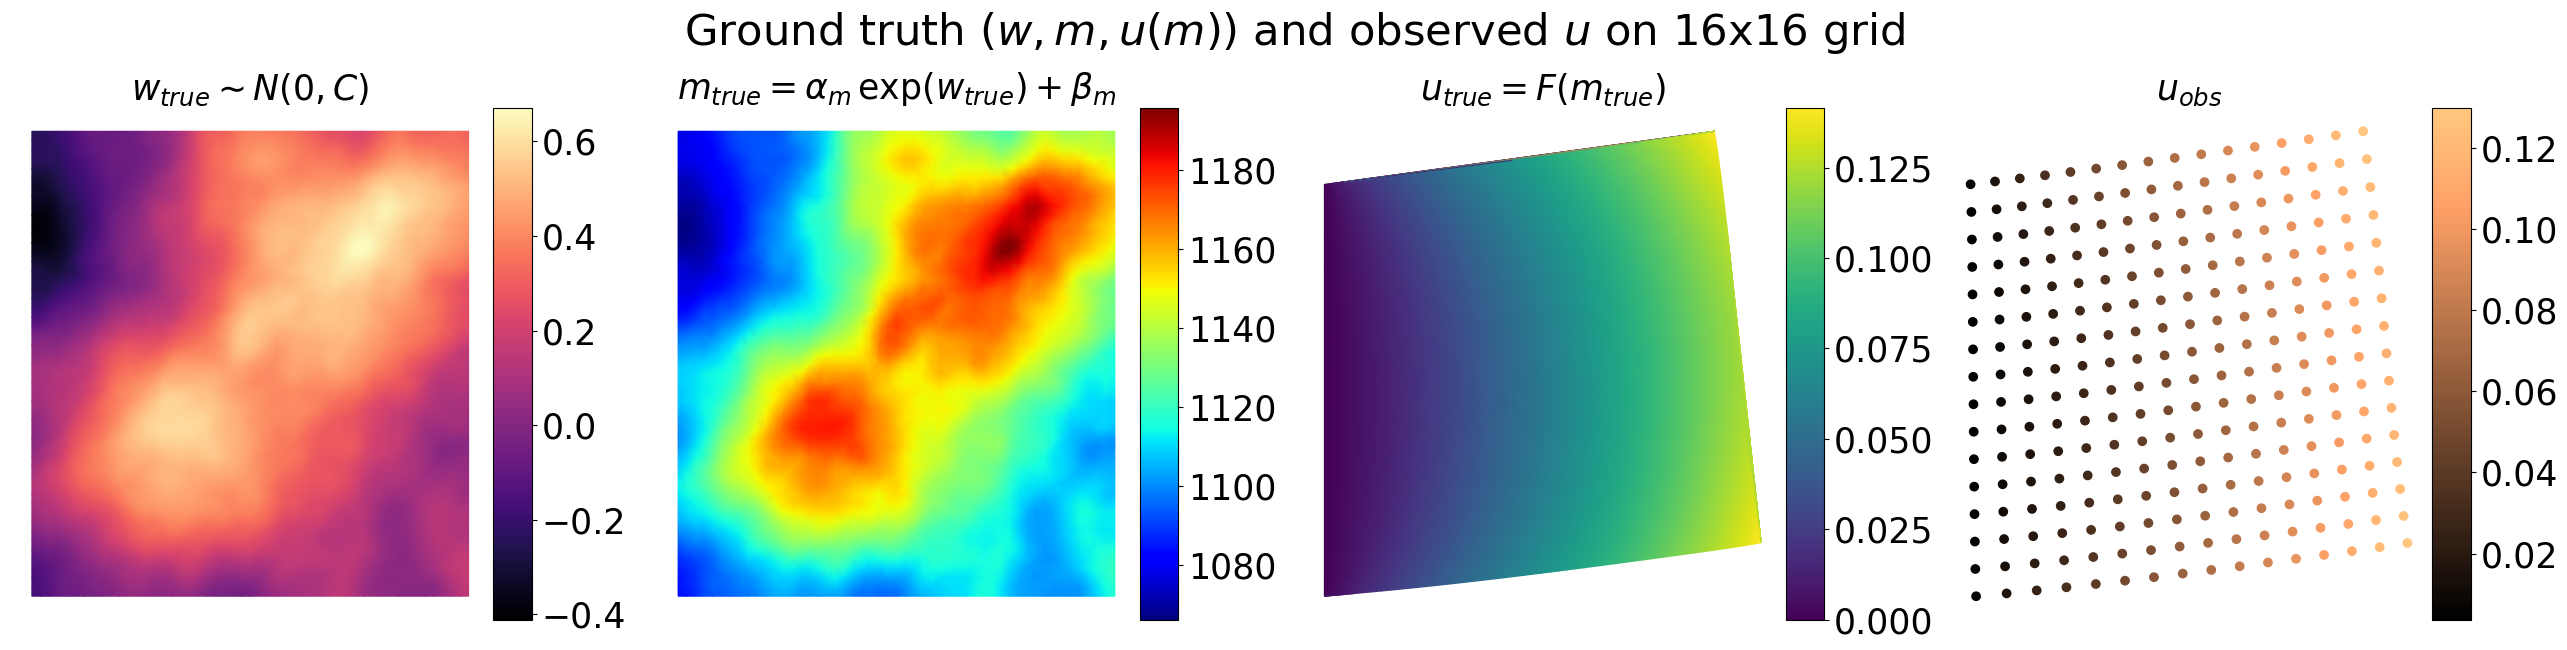

In [36]:
# plot
uvec = [[w_true, m_true, u_true, u_obs]]
title_vec = [[r'$w_{true} \sim N(0, C)$', r'$m_{true} = \alpha_m\, \exp(w_{true}) + \beta_m$', r'$u_{true} = F(m_{true})$', r'$u_{obs}$']]
cmap_vec = [['magma', 'jet', 'viridis', 'copper']]
flag_is_vec = [[False, False, True, True]]
flag_add_disp = [[False, False, True, True]]
plot_type = [['field', 'field', 'field', 'point']]
sup_title = r'Ground truth $(w, m, u(m))$ and observed $u$ on {}x{} grid'.format(num_grid_x, num_grid_y)
savefilename = results_dir + 'true_and_obs_w_m_u.png'

plot_data = get_default_plot_mix_collection_data(rows = 1, \
    cols = 4, \
    nodes = model.u_nodes, \
    nodes_point_plot = x_obs, \
    figsize = (26, 6), fs = 25, \
    sup_title =  sup_title, \
    y_sup_title = 1.075, \
    savefilename = savefilename, \
    u = uvec, cmap = cmap_vec, title = title_vec, \
    is_vec = flag_is_vec, add_disp = flag_add_disp, \
    plot_type = plot_type)

plot_mix_collection(plot_data)

u_obs.shape = (512,)
x_obs_def.shape = (256, 2)
x_obs_def.shape = (256, 2)


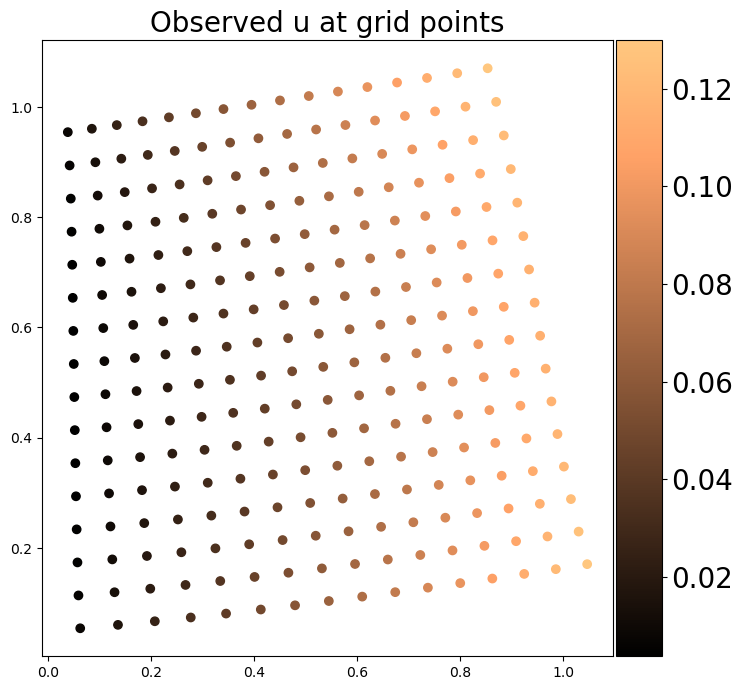

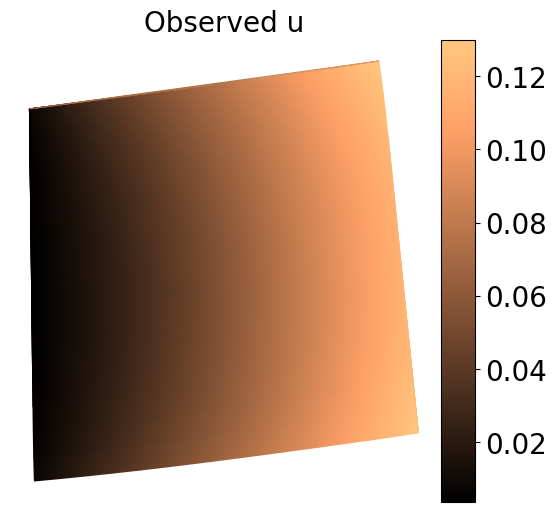

In [33]:
num_grid_xy = num_grid_x*num_grid_y

x_obs_def = np.zeros((num_grid_xy, 2))
x_obs_def[:, 0] = x_obs[:, 0] + u_obs[0:num_grid_xy]
x_obs_def[:, 1] = x_obs[:, 1] #+ u_obs[num_grid_xy:2*num_grid_xy]

print('u_obs.shape = {}'.format(u_obs.shape))
print('x_obs_def.shape = {}'.format(x_obs_def.shape))
print('x_obs_def.shape = {}'.format(x_obs_def.shape))

quick_point_plot(u_obs, x_obs_def, title='Observed u at grid points', cmap ='copper', is_displacement=True, add_displacement_to_nodes=True)

quick_field_plot(u_obs, x_obs, title='Observed u', cmap ='copper', is_displacement=True, add_displacement_to_nodes=True)

x_obs.shape = (256, 2)
grid_w.shape = (256,), grid_m.shape = (256,), grid_u.shape = (256, 2)


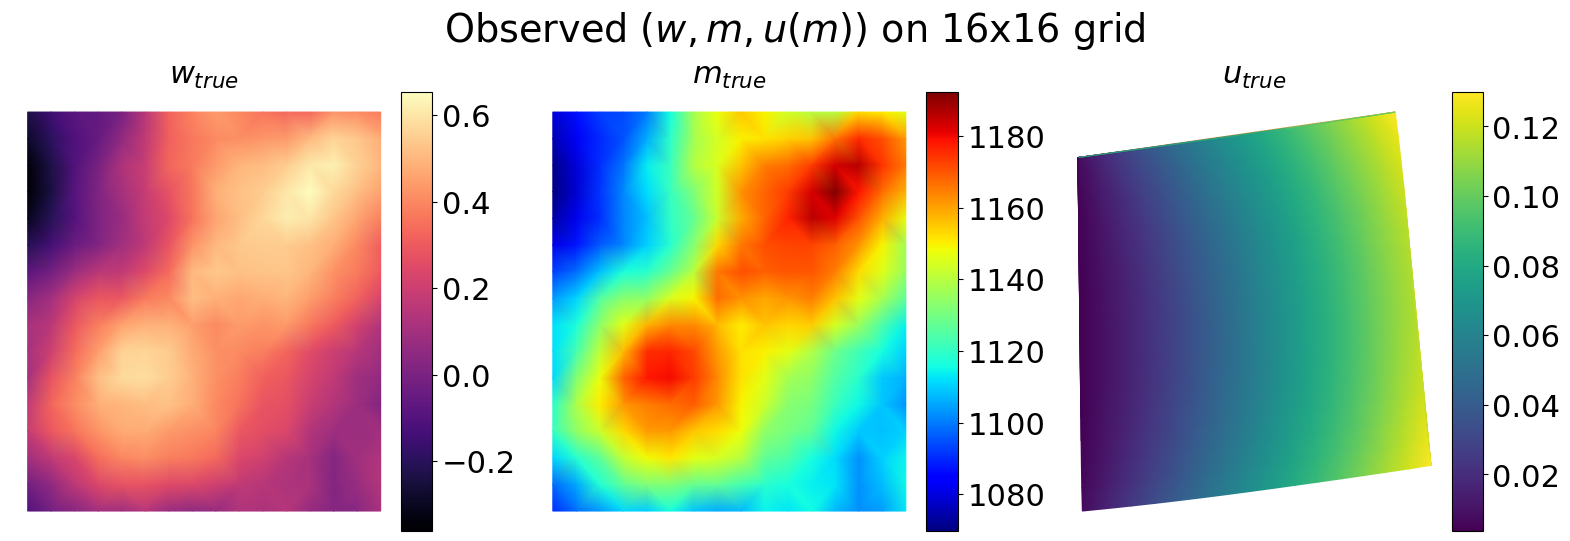

In [34]:
## Test if we can get interpolate on flattened nodes

# get set of points on area of interest
num_grid_x, num_grid_y = 16, 16
grid_x, grid_y = np.meshgrid(np.linspace(0.05, 0.95, num_grid_x), np.linspace(0.05, 0.95, num_grid_y), indexing='ij')
x_obs = np.vstack([grid_x.flatten(), grid_y.flatten()]).T

print('x_obs.shape = {}'.format(x_obs.shape))

# interpolate u at grid points
# grid_w = griddata(model.m_nodes, w_true, (grid_x, grid_y), method='linear')
grid_w = griddata(model.m_nodes, w_true, x_obs, method='linear')
grid_m = griddata(model.m_nodes, m_true, x_obs, method='linear')

# since u is a vector field, we need to interpolate each component separately
num_nodes = model.u_nodes.shape[0]
grid_u = np.zeros((x_obs.shape[0], 2))
for i in range(2):
    grid_u[:, i] = griddata(model.u_nodes, u_true[i*num_nodes:(i+1)*num_nodes], x_obs, method='linear')

print('grid_w.shape = {}, grid_m.shape = {}, grid_u.shape = {}'.format(grid_w.shape, grid_m.shape, grid_u.shape))

# save ground truth
w_obs = grid_w.flatten() 
m_obs = grid_m.flatten() 
num_grid_nodes = x_obs.shape[0]
u_obs = np.zeros(num_grid_nodes*2)
for i in range(2):
    u_obs[i*num_grid_nodes:(i+1)*num_grid_nodes] = grid_u[:, i]

# plot
uvec = [[w_obs, m_obs, u_obs]]
title_vec = [[r'$w_{true}$', r'$m_{true}$', r'$u_{true}$']]
cmap_vec = [['magma', 'jet', 'viridis']]
flag_is_vec = [[False, False, True]]
flag_add_disp = [[False, False, True]]
plot_type = [['field' for _ in range(3)]]

plot_data = get_default_plot_mix_collection_data(rows = 1, \
    cols = 3, \
    nodes = x_obs, \
    figsize = (16, 5), fs = 22, \
    sup_title =  r'Observed $(w, m, u(m))$ on {}x{} grid'.format(num_grid_x, num_grid_y), \
    y_sup_title = 1.075, \
    savefilename = None, \
    u = uvec, cmap = cmap_vec, title = title_vec, \
    is_vec = flag_is_vec, add_disp = flag_add_disp, \
    plot_type = plot_type)

plot_mix_collection(plot_data)

# plot_collection_grid(uvec, 1, 3, grid_x, grid_y, \
#                     title_vec = title_vec, sup_title = r'Observed $(w, m, u(m))$ on {}x{} grid'.format(num_grid_x, num_grid_y), \
#                     cmapvec = cmap_vec, fs = 25, \
#                     figsize = (20, 6), \
#                     y_sup_title = 1.075, \
#                     savefilename = results_dir + 'observed_w_m_u.png')